# Creating custom devices from S-Parameters

In design photonic circuits, you may encounter situations in which you require devices that haven't been pre-characterized and included in Simphony. In these cases, you must manually calculate the frequency-dependent S-parameters yourself and create your own device

In [1]:
#Base class of a Simphony Model
from simphony.elements import Model

from simphony.library import siepic           
from simphony.netlist import Subcircuit
from simphony.simulation import SweepSimulation

#Helper function
from simphony.tools import freq2wl

import numpy as np
import matplotlib.pyplot as plt

Your custom model must extend the Simphony-provided model and implement two fields and one function:

 - pins: a tuple of the default names of the pins, with the length of the tuple equally the number of ports
 - freq_range: a tuple in the form (lowest_frequency, highest_frequency)
 - s_parameters(freq): a function that accepts an array of frequencies and returns an three-dimensional array: 
     * Dimension 1 = length of input array
     * Dimension 2 = length of ports, representing input port
     * Dimension 3 = length of ports, representing output port
     
To implement the s_parameters function, we first write our s-parameters to a csv file in the form wavelength, s11, s12, s21, s22. We read this file, then interpolate to find the s-parameters corresponding to a given frequency

In [2]:
#Read from the csv file
sparams_raw = np.genfromtxt("sparams.csv",delimiter=",")

In [3]:
#Formats S-params conveniently as complex numbers
freqs = sparams_raw[:, 0]
sparams = np.zeros((sparams_raw.shape[0], 2, 2), dtype=np.cdouble)

S11 = sparams_raw[:, 1] + 1j*sparams_raw[:, 2]
S21 = sparams_raw[:, 3] + 1j*sparams_raw[:, 4]

#Assume symmetry
sparams[:,0,0] = S11
sparams[:,1,1] = S11
sparams[:,1,0] = S21
sparams[:,0,1] = S21

#Also formatted as angle/magnitude pairs for interpolation
S11_angle = np.unwrap(np.angle(S11))
S21_angle = np.unwrap(np.angle(S21))
S11_mag   = np.abs(S11)
S21_mag   = np.abs(S21)

In [4]:
#Function that interpolates table to find single frequency
def s_params_single(freq):
    minVal = freqs[0]
    maxVal = freqs[-1]
    if freq < minVal or freq > maxVal:
        raise Exception("Frequency value out of range")
    
    #Edge case that will break loop below
    if freq == maxVal:
        return sparams[-1,:,:]
    
    #Finds interval
    for i in range(len(freqs)):
        if freq <= freqs[i+1]:
            #Found interval
            angle11 = interp(freq, freqs[i], freqs[i+1], S11_angle[i], S11_angle[i+1])
            angle21 = interp(freq, freqs[i], freqs[i+1], S21_angle[i], S21_angle[i+1])
            mag11 = interp(freq, freqs[i], freqs[i+1], S11_mag[i], S11_mag[i+1])
            mag21 = interp(freq, freqs[i], freqs[i+1], S21_mag[i], S21_mag[i+1])
            val11 = mag11*np.exp(1j*angle11)
            val21 = mag21*np.exp(1j*angle21)
            return np.array([[val11, val21], [val21, val11]])
        
    raise Exception("Unexpected error in s_params")
    
def interp(x, x1, x2, y1, y2):
    return (y2 - y1)/(x2 - x1)*(x - x1) + y1

#Function that operates on an array of frequencies
def getParams(freqs):
    returnVal = np.zeros((len(freqs), 2, 2), dtype=np.cdouble)
    for i in range(len(freqs)):
        returnVal[i] = s_params_single(freqs[i])
    return returnVal

In [5]:
example_freqs  = np.linspace(freqs[0],freqs[-1],100)
example_params = getParams(example_freqs)

Text(0, 0.5, 'Proportional Magnitude')

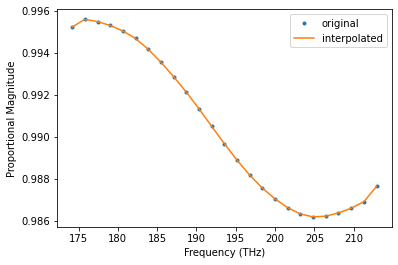

In [6]:
plt.plot(freqs/1e12, np.abs(sparams[:,1,0]), ".",label="original")
plt.plot(example_freqs/1e12, np.abs(example_params[:,1,0]), "-",label="interpolated")
plt.legend()
plt.xlabel("Frequency (THz)")
plt.ylabel("Proportional Magnitude")

Text(0, 0.5, 'Phase')

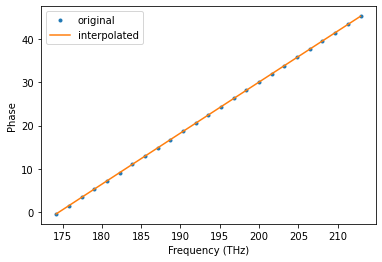

In [7]:
plt.plot(freqs/1e12, np.unwrap(np.angle(sparams[:,1,0])), ".",label="original")
plt.plot(example_freqs/1e12, np.unwrap(np.angle(example_params[:,1,0])), "-",label="interpolated")
plt.legend()
plt.xlabel("Frequency (THz)")
plt.ylabel("Phase")

# Creating Model Object

With the s-parameter interpolation out of the way, we're now ready to create the corresponding Simphony Model object

In [8]:
class Bend(Model):
    
    def __init__(self):
        self.pins = ("input", "output")
        self.freq_range = (freqs[0], freqs[-1])
    
    def s_parameters(self, freqs):
        return getParams(freqs)
    

# Creating the Circuit

Just as before, we instantiate the model and create a circuit. In this case, we just create a simple circuit with input/output waveguides and a single bend

Text(0, 0.5, 'Output Magnitude Proportion')

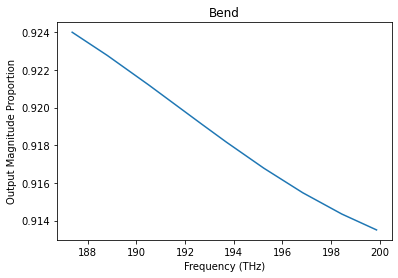

In [13]:
#gratingCoupler = siepic.ebeam_gc_te1550()
waveguide = siepic.ebeam_wg_integral_1550(length=200e-6)
bend           = Bend()

circuit = Subcircuit("Bend")

e = circuit.add([
    (waveguide, "input"),
    (     bend, "bend"),
    (waveguide, "output"),
])

circuit.elements["input"].pins["n2"] = "input"
circuit.elements["output"].pins["n2"] = "output"

circuit.connect_many([
    ("input",     "n1",   "bend", "input"),
    ( "bend", "output", "output",    "n1"),
])

simulation = SweepSimulation(circuit, 1500e-9, 1600e-9)
result     = simulation.simulate()

f, s = result.data("input", "output")

plt.plot(f/1e12,s)
plt.title("Bend")
plt.xlabel("Frequency (THz)")
plt.ylabel("Output Magnitude Proportion")

# Alternative: Grating Couplers

An identical circuit except with grating couplers instead of waveguides

Text(0, 0.5, 'Output Magnitude Proportion')

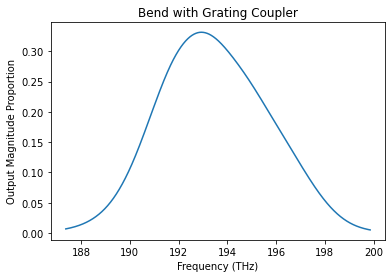

In [10]:
gratingCoupler = siepic.ebeam_gc_te1550()
bend           = Bend()

circuit = Subcircuit("Bend")

e = circuit.add([
    (gratingCoupler, "input"),
    (          bend, "bend"),
    (gratingCoupler, "output"),
])

circuit.elements["input"].pins["n2"] = "input"
circuit.elements["output"].pins["n2"] = "output"

circuit.connect_many([
    ("input",     "n1",   "bend", "input"),
    ( "bend", "output", "output",    "n1"),
])

simulation = SweepSimulation(circuit, 1500e-9, 1600e-9)
result     = simulation.simulate()

f, s = result.data("input", "output")

plt.plot(f/1e12,s)
plt.title("Bend with Grating Coupler")
plt.xlabel("Frequency (THz)")
plt.ylabel("Output Magnitude Proportion")